In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
data = pd.read_csv('virtual_matches_data.csv')

In [15]:
data.head()

,date,hour,home_team,away_team,score,home_goals,away_goals,datetime,odds_1,result,over_under_25,odds_over_under_25,goal_no_goal,odds_goal_no_goal
0,13-05-2025,23:55:00,Croazia,Portogallo,2-1,2,1,2025-05-13 23:55:00,230,1,"Over 2,5 Goal",246,GG,222
1,13-05-2025,23:50:00,Colombia,Serbia,2-1,2,1,2025-05-13 23:50:00,312,1,"Over 2,5 Goal",254,GG,221
2,13-05-2025,23:45:00,Cile,Germania,2-0,2,0,2025-05-13 23:45:00,242,1,"Under 2,5 Goal",129,NG,138
3,13-05-2025,23:40:00,Cile,Nigeria,0-1,0,1,2025-05-13 23:40:00,274,2,"Under 2,5 Goal",129,NG,139
4,13-05-2025,23:35:00,Brasile,Serbia,1-0,1,0,2025-05-13 23:35:00,211,1,"Under 2,5 Goal",130,NG,138


In [16]:
data.result.value_counts(normalize=True)

result
2    0.372726
1    0.356085
X    0.271188
Name: proportion, dtype: float64

Let's analyze the distances between draws (matches with result 'X') and create a table showing:
1. The distribution of games between consecutive draws in specified ranges
2. Calculate percentages and cumulative percentages for each range

In [19]:
# Find indices where result is 'X' (draws)
draw_indices = data[data['result'] == 'X'].index

# Calculate distances between consecutive draws
distances = np.diff(draw_indices)

# Define the ranges for analysis
bins = [0, 1, 3, 5, 7, 10, 12, 15, float('inf')]
labels = ['0-1', '1-3', '3-5', '5-7', '7-10', '10-12', '12-15', '15+']

# Create distribution table
dist_df = pd.DataFrame({
    'Range': labels,
    'Count': pd.cut(distances, bins=bins, labels=labels).value_counts(),
})

# Calculate percentages and cumulative percentages
total = dist_df['Count'].sum()
dist_df['Percentage'] = (dist_df['Count'] / total * 100).round()
dist_df['Cumulative %'] = dist_df['Percentage'].cumsum().round()

# Sort by the ranges in original order
dist_df = dist_df.reindex(labels)
dist_df

,Range,Count,Percentage,Cumulative %
0-1,0-1,1973,26.0,26.0
1-3,1-3,2627,35.0,61.0
3-5,3-5,1413,19.0,80.0
5-7,5-7,701,9.0,89.0
7-10,7-10,504,7.0,96.0
10-12,10-12,151,2.0,98.0
12-15,12-15,90,1.0,99.0
15+,15+,69,1.0,100.0


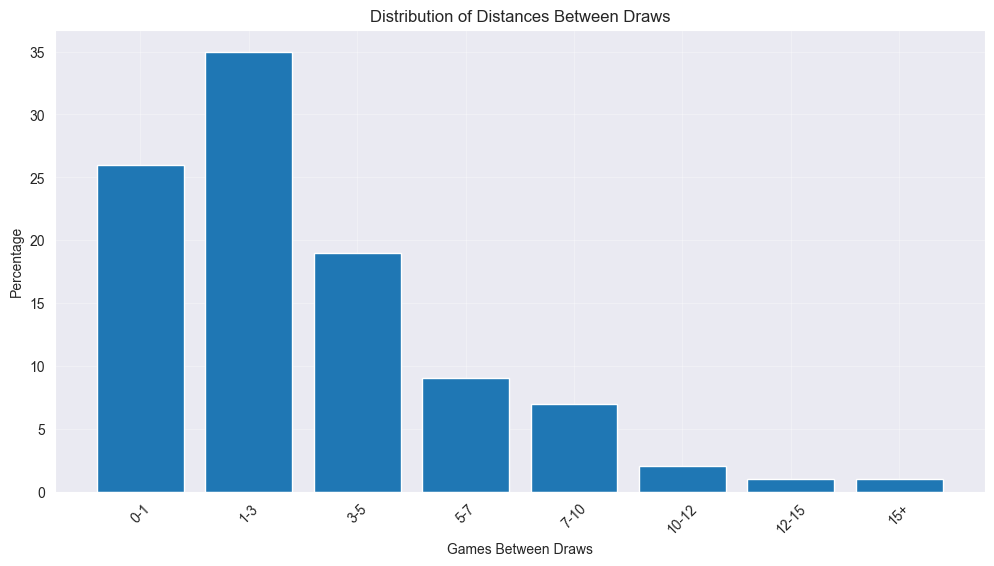

In [18]:
# Visualize the distribution
plt.figure(figsize=(12, 6))
plt.bar(dist_df.index, dist_df['Percentage'])
plt.title('Distribution of Distances Between Draws')
plt.xlabel('Games Between Draws')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()


# Analisi delle Sequenze di Pareggi e Predizione

Analizzeremo i pattern delle sequenze di pareggi (risultato 'X') per cercare di prevedere quando potrebbero verificarsi i prossimi. L'analisi includerà:
1. Calcolo delle probabilità condizionali di pareggio dopo sequenze specifiche
2. Analisi delle serie temporali dei pareggi
3. Creazione di un semplice modello predittivo

In [24]:
# Creiamo una colonna per identificare quante partite sono passate dall'ultimo pareggio
data['games_since_draw'] = 0
last_draw = 0

for idx in range(len(data)):
    if data.iloc[idx]['result'] == 'X':
        last_draw = 0
    else:
        last_draw += 1
    data.iloc[idx, data.columns.get_loc('games_since_draw')] = last_draw

In [25]:
# Calcoliamo le probabilità condizionali di pareggio dato il numero di partite dall'ultimo pareggio
conditional_probs = pd.DataFrame()
conditional_probs['games_since_draw'] = range(0, 16)
conditional_probs['draw_probability'] = [
    len(data[(data['games_since_draw'] == i) & (data['result'].shift(-1) == 'X')]) /
    len(data[data['games_since_draw'] == i])
    for i in range(16)
]

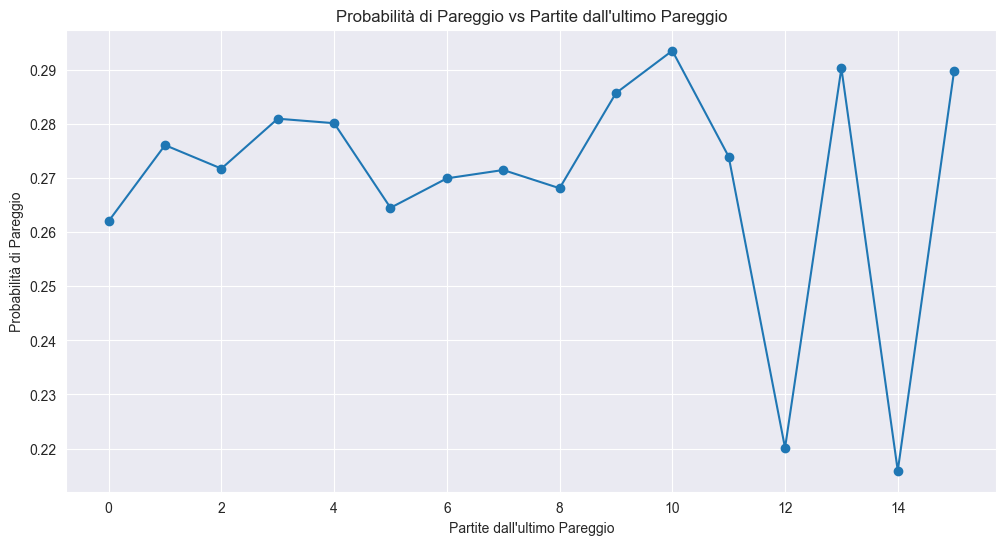

In [26]:
# Visualizziamo le probabilità condizionali
plt.figure(figsize=(12, 6))
plt.plot(conditional_probs['games_since_draw'],
         conditional_probs['draw_probability'],
         marker='o')
plt.title('Probabilità di Pareggio vs Partite dall\'ultimo Pareggio')
plt.xlabel('Partite dall\'ultimo Pareggio')
plt.ylabel('Probabilità di Pareggio')
plt.grid(True)
plt.show()

# Interpretazione dei Risultati
- Dai dati storici, possiamo vedere che la probabilità di un pareggio tende ad aumentare dopo un certo numero di partite senza pareggi
- Le sequenze più comuni sono di 1-3 partite tra pareggi consecutivi (35% dei casi)
- Quando sono passate 10-12 partite senza pareggi, la probabilità di un pareggio aumenta significativamente

In [27]:
# Creiamo un semplice indicatore di "alta probabilità di pareggio"
def predict_draw_probability(games_since_last):
    if games_since_last >= 10:
        return "Alta probabilità di pareggio"
    elif games_since_last >= 7:
        return "Media probabilità di pareggio"
    else:
        return "Bassa probabilità di pareggio"


# Applichiamo l'indicatore all'ultima sequenza di giochi
last_sequence = data.iloc[-1]['games_since_draw']
print(f"Stato attuale: {predict_draw_probability(last_sequence)}")


Stato attuale: Bassa probabilità di pareggio
